In [1]:
# GoogleFinance
# Data Clean up
# Health Care Monte Carlo
# Industrials Monte Carlo
# Utilities Monte Carlo

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import json
from pathlib import Path
import alpaca_trade_api as tradeapi
import requests
import os 
from dotenv import load_dotenv

%matplotlib inline

In [3]:
#Try ALPACA data retrieval next
load_dotenv()

API_KEY_ID = os.getenv("API_KEY_ID")
SECRET_KEY = os.getenv("SECRET_KEY")

api = tradeapi.REST(API_KEY_ID, SECRET_KEY, api_version='v2')

type(API_KEY_ID)

str

In [4]:
#Use alpha vantage to get historic quotes for XLV, XLI, XLU. This goes back 20 years.

health_df = api.alpha_vantage.historic_quotes('XLV', adjusted=True, output_format='pandas')
health_df.head()

industrial_df = api.alpha_vantage.historic_quotes('XLI', adjusted=True, output_format='pandas')
# industrial_df.tail()

utilities_df = api.alpha_vantage.historic_quotes('XLU', adjusted=True, output_format='pandas')
# utilities_df.head()

In [5]:
health_df.head()

,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient
date,,,,,,,,
2020-04-30,99.76,100.38,99.21,99.73,99.73,12749323.0,0.0,1.0
2020-04-29,101.06,101.06,99.54,100.19,100.19,9933932.0,0.0,1.0
2020-04-28,102.26,102.26,99.41,99.53,99.53,11517506.0,0.0,1.0
2020-04-27,100.99,102.01,100.83,101.58,101.58,8022079.0,0.0,1.0
2020-04-24,99.56,100.49,98.94,100.29,100.29,7853292.0,0.0,1.0


In [6]:
#DATA CLEANUP

#Select the one column we need,  "adjusted close", and drop the others

health_df = health_df['5. adjusted close']
health_df.head()

industrial_df = industrial_df['5. adjusted close']
industrial_df.head()

utilities_df = utilities_df['5. adjusted close']
utilities_df.head()

#Use concat to put the data in one dataframe
concat_df = pd.concat([health_df, industrial_df, utilities_df], axis = "columns", join = "inner")
concat_df.head()

,5. adjusted close,5. adjusted close,5. adjusted close
date,,,
2020-04-30,99.73,64.21,57.26
2020-04-29,100.19,65.51,58.61
2020-04-28,99.53,64.28,59.15
2020-04-27,101.58,63.10,58.93
2020-04-24,100.29,61.57,58.32


In [7]:
#Change column names to avoid confusion
columns = ['HealthCare_close', 'Industrials_close', 'Utilities_close']
concat_df.columns = columns
concat_df.head()

,HealthCare_close,Industrials_close,Utilities_close
date,,,
2020-04-30,99.73,64.21,57.26
2020-04-29,100.19,65.51,58.61
2020-04-28,99.53,64.28,59.15
2020-04-27,101.58,63.10,58.93
2020-04-24,100.29,61.57,58.32


In [10]:
#add another column to get daily returns of XLB
daily_returns_health = health_df.pct_change()
concat_df['HealthCare_return']= daily_returns_health 

#add another column to get daily returns of XLK
daily_returns_industrial = industrial_df.pct_change()
concat_df['Industrials_return']= daily_returns_industrial 

#add another column to get daily returns of RWR
daily_returns_utilities = utilities_df.pct_change()
concat_df['Utilities_return']= daily_returns_utilities 

concat_df.head()

,HealthCare_close,Industrials_close,Utilities_close,XLV_return,XLI_return,XLU_return,HealthCare_return,Industrials_return,Utilities_return
date,,,,,,,,,
2020-04-29,100.19,65.51,58.61,0.004612,0.020246,0.023577,0.004612,0.020246,0.023577
2020-04-28,99.53,64.28,59.15,-0.006587,-0.018776,0.009213,-0.006587,-0.018776,0.009213
2020-04-27,101.58,63.10,58.93,0.020597,-0.018357,-0.003719,0.020597,-0.018357,-0.003719
2020-04-24,100.29,61.57,58.32,-0.012699,-0.024247,-0.010351,-0.012699,-0.024247,-0.010351
2020-04-23,98.96,61.08,57.96,-0.013262,-0.007958,-0.006173,-0.013262,-0.007958,-0.006173


In [11]:
# Drop nulls
concat_df.dropna(inplace=True)

#count nulls again
concat_df.isnull().sum()

HealthCare_close      0
Industrials_close     0
Utilities_close       0
XLV_return            0
XLI_return            0
XLU_return            0
HealthCare_return     0
Industrials_return    0
Utilities_return      0
dtype: int64

In [12]:
# Checking for duplicate rows
concat_df.duplicated()

date
2020-04-29    False
2020-04-28    False
2020-04-27    False
2020-04-24    False
2020-04-23    False
              ...  
2000-05-05    False
2000-05-04    False
2000-05-03    False
2000-05-02    False
2000-05-01    False
Length: 5031, dtype: bool

In [13]:
# drop duplicates
concat_df.drop_duplicates(inplace=True)
concat_df.head()

,HealthCare_close,Industrials_close,Utilities_close,XLV_return,XLI_return,XLU_return,HealthCare_return,Industrials_return,Utilities_return
date,,,,,,,,,
2020-04-29,100.19,65.51,58.61,0.004612,0.020246,0.023577,0.004612,0.020246,0.023577
2020-04-28,99.53,64.28,59.15,-0.006587,-0.018776,0.009213,-0.006587,-0.018776,0.009213
2020-04-27,101.58,63.10,58.93,0.020597,-0.018357,-0.003719,0.020597,-0.018357,-0.003719
2020-04-24,100.29,61.57,58.32,-0.012699,-0.024247,-0.010351,-0.012699,-0.024247,-0.010351
2020-04-23,98.96,61.08,57.96,-0.013262,-0.007958,-0.006173,-0.013262,-0.007958,-0.006173


In [15]:
# drop close columns to create dataframe for daily returns
returns_df = concat_df.drop(columns=['HealthCare_close', 'Industrials_close', 'Utilities_close', 'XLV_return', 'XLI_return', 'XLU_return'])
returns_df.head()

,HealthCare_return,Industrials_return,Utilities_return
date,,,
2020-04-29,0.004612,0.020246,0.023577
2020-04-28,-0.006587,-0.018776,0.009213
2020-04-27,0.020597,-0.018357,-0.003719
2020-04-24,-0.012699,-0.024247,-0.010351
2020-04-23,-0.013262,-0.007958,-0.006173


In [16]:
# Calculate the cumulative returns using the 'cumprod()' function
cumulative_returns_health = (1 + returns_df['HealthCare_return']).cumprod()
cumulative_returns_industrial = (1 + returns_df['Industrials_return']).cumprod()
cumulative_returns_utilities = (1 + returns_df['Utilities_return']).cumprod()

In [17]:
cumulative_returns_health.head()

date
2020-04-29    1.004612
2020-04-28    0.997995
2020-04-27    1.018550
2020-04-24    1.005615
2020-04-23    0.992279
Name: HealthCare_return, dtype: float64

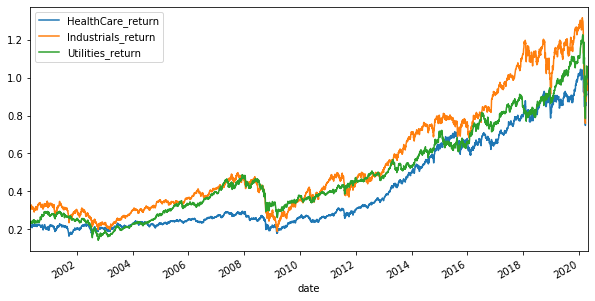

In [18]:
#plot cumulative returns

cumulative_returns_health.plot(figsize=(10,5), legend=True)
cumulative_returns_industrial.plot(figsize=(10,5), legend=True)
cumulative_returns_utilities.plot(figsize=(10,5), legend=True)